In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

#download file
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

#unzip file
!unzip -nq UCI-HAR.zip

#buat random seed
np.random.seed(0)
tf.random.set_seed(0)

#angka dibawah ini didapat setelah memerika file
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # 9 => banyaknya files
K = 6 # 6 => jumlah class

def load_data():
  #buat variable untuk data train dan test
  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  #data training
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}',header=None,delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x
  
  #label data training
  Ytrain = pd.read_csv(f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
  Ytrain = Ytrain.flatten()

  #data testing
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}',header=None,delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x
  
  #label data testing
  Ytest = pd.read_csv(f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest

--2022-01-11 08:33:08--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI-HAR.zip’

UCI-HAR.zip         100%[===================>]  58.17M  22.9MB/s    in 2.5s    

2022-01-11 08:33:11 (22.9 MB/s) - ‘UCI-HAR.zip’ saved [60999314/60999314]



In [2]:
#tes fungsi diatas
Xtrain, Ytrain, Xtest, Ytest = load_data()

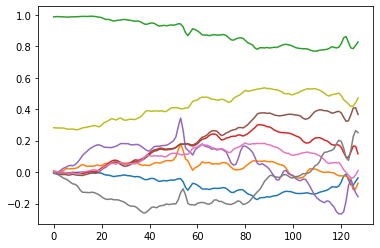

In [3]:
# plot semua D=9 time series dari panjang T=128
plt.plot(Xtrain[7000, :, :]);

In [5]:
#buat model CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

#buat summary dari model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 32)           1472      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 41, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 17, 128)           2470

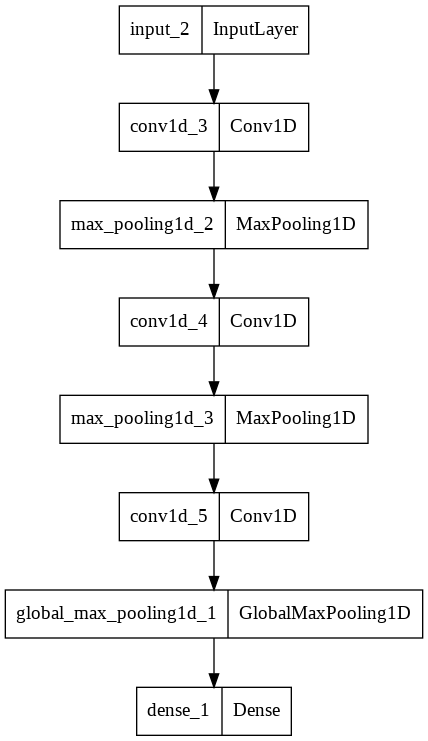

In [6]:
tf.keras.utils.plot_model(model)

In [9]:
#buat cekpoint model
check_point = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

#buat compiler
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

#buat fit model
r = model.fit(Xtrain,Ytrain,epochs=15,callbacks=[check_point],validation_data=(Xtest, Ytest))

Epoch 1/15
230/230 [==============================] - 4s 15ms/step - loss: 0.4130 - accuracy: 0.8541 - val_loss: 0.2636 - val_accuracy: 0.9070
Epoch 2/15
230/230 [==============================] - 3s 14ms/step - loss: 0.1192 - accuracy: 0.9543 - val_loss: 0.2839 - val_accuracy: 0.9070
Epoch 3/15
230/230 [==============================] - 3s 14ms/step - loss: 0.1079 - accuracy: 0.9540 - val_loss: 0.2390 - val_accuracy: 0.9135
Epoch 4/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0966 - accuracy: 0.9604 - val_loss: 0.2175 - val_accuracy: 0.9260
Epoch 5/15
230/230 [==============================] - 3s 13ms/step - loss: 0.0942 - accuracy: 0.9623 - val_loss: 0.2204 - val_accuracy: 0.9162
Epoch 6/15
230/230 [==============================] - 3s 13ms/step - loss: 0.0849 - accuracy: 0.9641 - val_loss: 0.2127 - val_accuracy: 0.9145
Epoch 7/15
230/230 [==============================] - 3s 13ms/step - loss: 0.0797 - accuracy: 0.9665 - val_loss: 0.2411 - val_accuracy: 0.9152

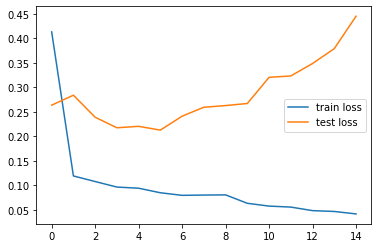

In [10]:
#buat plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

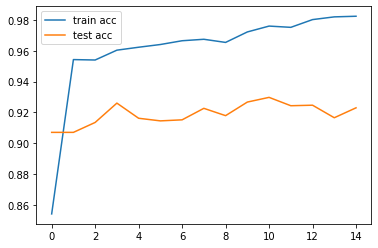

In [11]:
#buat plot
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [12]:
#load model terbaik
best_model = tf.keras.models.load_model('best_model.h5')

#buat prediksi
Ptest = best_model.predict(Xtest)

#evaluasi
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9297590770274856

In [13]:
#fungsi 2
def load_features():
  #data train
  df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)
  
  feat_train = df.to_numpy()

  #data testing
  df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)
  
  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [14]:
#tes fungsi 2
feat_train, feat_test = load_features()

In [15]:
#buat variable
D_feat = feat_train.shape[1]

In [19]:
# Combined Model

# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(64, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

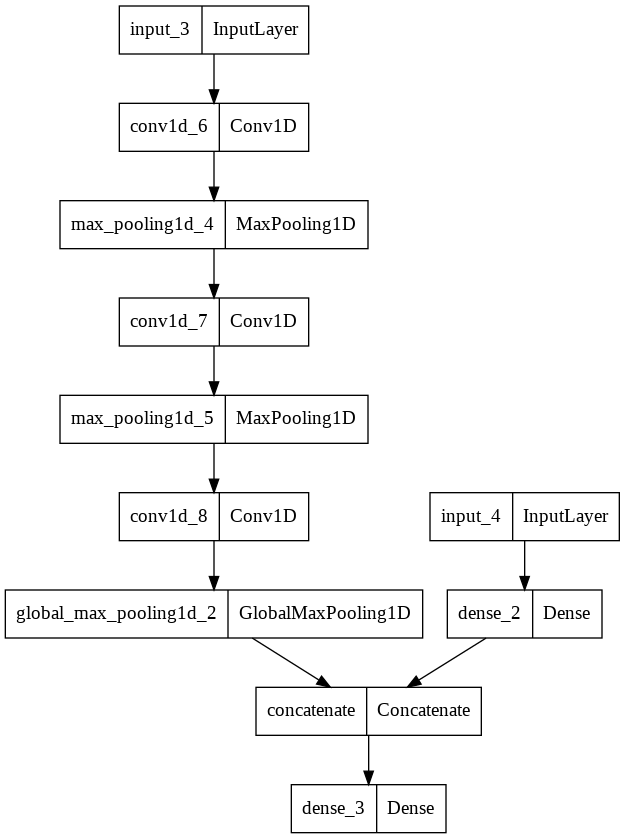

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
#buat cek point 3
check_point3 = ModelCheckpoint('best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

#buat compiler
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

#buat fit model
r = model.fit([Xtrain, feat_train],Ytrain,epochs=15,callbacks=[check_point3],validation_data=([Xtest, feat_test], Ytest),)

Epoch 1/15
230/230 [==============================] - 4s 16ms/step - loss: 0.2272 - accuracy: 0.9151 - val_loss: 0.1553 - val_accuracy: 0.9389
Epoch 2/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0717 - accuracy: 0.9710 - val_loss: 0.1881 - val_accuracy: 0.9318
Epoch 3/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0506 - accuracy: 0.9800 - val_loss: 0.1382 - val_accuracy: 0.9505
Epoch 4/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0431 - accuracy: 0.9827 - val_loss: 0.1534 - val_accuracy: 0.9508
Epoch 5/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0383 - accuracy: 0.9857 - val_loss: 0.1390 - val_accuracy: 0.9539
Epoch 6/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0364 - accuracy: 0.9859 - val_loss: 0.1334 - val_accuracy: 0.9559
Epoch 7/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0294 - accuracy: 0.9894 - val_loss: 0.2037 - val_accuracy: 0.9399

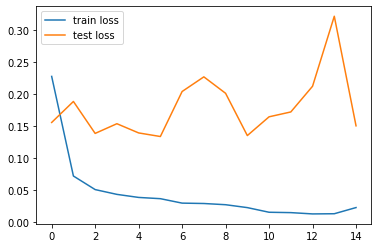

In [22]:
#buat plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

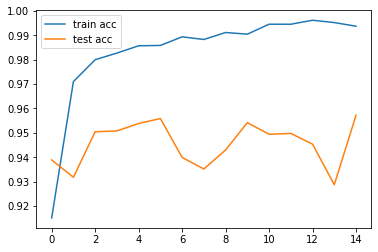

In [23]:
#buat plot
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [24]:
#load model terbaik
best_model = tf.keras.models.load_model('best_model_combined.h5')

#buat prediksi
Ptest = best_model.predict([Xtest, feat_test])

#evaluasi
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9572446555819477

# Logistic Regression

In [25]:
#import
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

#buatmodel
model = LogisticRegression(solver='liblinear')

#fit model
model.fit(feat_train, Ytrain)

#score model
print("Score model untuk data training:", model.score(feat_train, Ytrain))
print("Score model untuk data testing:", model.score(feat_test, Ytest))

Score model untuk data training: 0.9945593035908596
Score model untuk data testing: 0.9613165931455717


# SVC

In [26]:
#buatmodel
model = SVC()

#fit model
model.fit(feat_train, Ytrain)

#score model
print("Score model untuk data training:", model.score(feat_train, Ytrain))
print("Score model untuk data testing:", model.score(feat_test, Ytest))

Score model untuk data training: 0.9866702937976061
Score model untuk data testing: 0.9521547336274178


# Random Forest Classifier

In [27]:
#buatmodel
model = RandomForestClassifier()

#fit model
model.fit(feat_train, Ytrain)

#score model
print("Score model untuk data training:", model.score(feat_train, Ytrain))
print("Score model untuk data testing:", model.score(feat_test, Ytest))

Score model untuk data training: 1.0
Score model untuk data testing: 0.9236511706820495
